# Engenharia de Software - MVP Sprint 4
# Avaliação de Viabilidade de Investimento em Fundos Multimercado

## *   Definição do Problema <br>
Estabelecer uma forma simples de avaliação de viabilidade de um fundo de investimento, com um nível razoável de assertividade, considerando um número mínimo de variáveis. Entendendo como viabilidade, a expectativa de retorno positivo em um período de carência de 30 (trinta) dias corridos.
## *   Coleta e Análise de Dados <br>
São utilizados dados diários dos fundos cadastrados na CVM para os seguintes atributos: Resgate do Dia [RESG_DIA], Captação no Dia [CAPTC_DIA], Número de Cotistas [NR_COTST] e Valor do Patrimônio Líquido [VL_PATRIM_LIQ].

--> Fonte: https://dados.cvm.gov.br/dataset/fi-doc-inf_diario

## *   Aplicação <br>
Executa o Pré-processamento, a Modelagem, a Inferência e a Finalização do Modelo.
Foram consideradas as seguintes restrições no Pré-processamento: <br><br>
1 - Valor da Cota [VL_QUOTA] > 0 por entender que um fundo com valor de cota negativo, já é um fundo "esgotado" que não deve estar na base de análise. Além disso, há o cálculo do RETORNO, que será dado por VL_QUOTA do mês M+1 (df_2) menos VL_QUOTA no mês M (df_1), dia a dia.<br>
2 - Número de Cotistas [NR_COTST] > 1.000 por avaliar, durante análises dos dados dos datasets, que valores menores afetavam significativamente o comportamento de resgates e captações diárias.<br>
3 - Valor do Patrimônio Líquido [VL_PATRIM_LIQ] > 1.000.000 por avaliar, durante análises dos dados dos datasets, que valores menores afetavam significativamente o comportamento de resgates e captações diárias.<br>
4 - Classe do Fundo [CLASSE] = Fundo Multimercado, por ser um fundo de investimento de perfil intermediário, não tão conservador quanto um Fundo de Renda Fixa, nem tão arrojado quanto um Fundo de Ações. Todos os demais fundos constantes nos datasets (Fundo de Curto Prazo, Fundo Cambial, Fundo Referenciado, Fundo da Dívida Externa e FMP-FGTS), são fundos de classes muito específicas.<br><br>
ATRIBUTO ALVO:: RETORNO = VL_QUOTA (M+1) - VL_QUOTA (M). Se RETORNO > 0, SUGESTÃO = 1, investimento VIÁVEL, caso contrário SUGESTÃO = 0, INVIÁVEL. (vide: Agregação). O atributo alvo será o campo [SUGESTÃO]<br>
## *   Simulação <br>
Disponibiliza a entrada de dados para realização de simulações sobre o modelo.
## *   Exportando Modelo <br>
Exporta para 'My Drive' no Google Drive,  um arquivo chamado "Modelo_FI_Multi.pkl" com o modelo definido.




# COLETA E ANÁLISE DE DADOS - Requirements, Imports, Carga e Análise dos Datasets

### _Requirements e Imports

In [113]:
!pip install gdown

In [114]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from google.colab import files
from IPython.display import display, display_html, HTML
from scipy import stats
from pickle import dump
from pickle import load

### _Carga dos Datasets

In [115]:
# Informa a URL de importação do dataset
id_arquivo_1 = '1R8vASJ_vSzykspidSdAVEXvnWIW8gIiG'
id_arquivo_2 = '1eFlNnCsX8HtRjAgPA2IsM-9nzKwG3FLD'
id_arquivo_cad = '1yO9-XahOdUOj00g9SyBBETASc84mRNtt'

# URLs para download direto dos arquivos
url_1 = f'https://drive.google.com/uc?id={id_arquivo_1}'
url_2 = f'https://drive.google.com/uc?id={id_arquivo_2}'
url_cad = f'https://drive.google.com/uc?id={id_arquivo_cad}'

# Faça o download dos arquivos
gdown.download(url_1, 'arquivo1.csv', quiet=False)
gdown.download(url_2, 'arquivo2.csv', quiet=False)
gdown.download(url_cad, 'arquivocad.csv', quiet=False)

# Lê o arquivo
df_1 = pd.read_csv('arquivo1.csv', delimiter=';')
df_2 = pd.read_csv('arquivo2.csv', delimiter=';')
df_cad = pd.read_csv('arquivocad.csv', delimiter=';')

# df_1 é o dataframe com os dados performance diária do mês M-1
# df_2 é o dataframe com os dados de performance diária do mês M
# df_cad é o dataframe com os dados de cadastro dos Fundos de Investimento

Downloading...
From: https://drive.google.com/uc?id=1R8vASJ_vSzykspidSdAVEXvnWIW8gIiG
To: /content/arquivo1.csv
100%|██████████| 46.2M/46.2M [00:00<00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eFlNnCsX8HtRjAgPA2IsM-9nzKwG3FLD
To: /content/arquivo2.csv
100%|██████████| 49.0M/49.0M [00:00<00:00, 91.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yO9-XahOdUOj00g9SyBBETASc84mRNtt
To: /content/arquivocad.csv
100%|██████████| 3.59M/3.59M [00:00<00:00, 25.2MB/s]


# APLICAÇÃO - Pré-processamento, Modelagem, Inferência e Finalização do Modelo

In [116]:
# Para não necessitar realizar carga dos datasets a cada execução da aplicação
# "df_sr" dataframe Sem Restrições e "df_cr" dataframe Com Restrições
df_sr1 = df_cr1 = df_1
df_sr2 = df_cr2 = df_2

## _Pré-processamento (Limpeza, Avaliação dos atributos, Separação Treino/Teste)

### __Análise Inicial dos Datasets

In [117]:
# Criação de DataFrames temporários para armazenar os tipos de dados e contagens
temp1 = pd.DataFrame(df_1.dtypes, columns=['df_1_dtypes'])
temp2 = pd.DataFrame(df_2.dtypes, columns=['df_2_dtypes'])
temp3 = pd.DataFrame(df_1.count(), columns=['df_1_count'])
temp4 = pd.DataFrame(df_2.count(), columns=['df_2_count'])

# Criação de DataFrames temporários para armazenar as informações de shape
temp5 = pd.DataFrame([df_1.shape], columns=['df_1_rows', 'df_1_cols'])
temp6 = pd.DataFrame([df_2.shape], columns=['df_2_rows', 'df_2_cols'])

# Concatenação dos DataFrames lado a lado
result = pd.concat([temp1, temp2, temp3, temp4], axis=1)

# Exibição do resultado
print(result)

              df_1_dtypes df_2_dtypes  df_1_count  df_2_count
TP_FUNDO           object      object      505556      537278
CNPJ_FUNDO         object      object      505556      537278
DT_COMPTC          object      object      505556      537278
VL_TOTAL          float64     float64      505556      537278
VL_QUOTA           object      object      505556      537278
VL_PATRIM_LIQ     float64     float64      505556      537278
CAPTC_DIA         float64     float64      505556      537278
RESG_DIA          float64     float64      505556      537278
NR_COTST            int64       int64      505556      537278


### __Estabelecendo as Restrições e Comparando os Dados

#### ____Restrição 1

In [118]:
# Adequando VL_QUOTA à quantidade de casas decimais informada no Dicionário de
# Dados do dataset de origem (Dicionário.txt)
df_cr1['VL_QUOTA'] = df_cr1['VL_QUOTA'].astype(str).str.replace('.', '')
df_cr1['VL_QUOTA'] = df_cr1['VL_QUOTA'].astype(float)
df_cr1['VL_QUOTA'] = df_cr1['VL_QUOTA'] / (10**12)

df_cr2['VL_QUOTA'] = df_cr2['VL_QUOTA'].astype(str).str.replace('.', '')
df_cr2['VL_QUOTA'] = df_cr2['VL_QUOTA'].astype(float)
df_cr2['VL_QUOTA'] = df_cr2['VL_QUOTA'] / (10**12)

# Aplicando a restrição 1 estabelecendo VL_QUOTA positivo
df_cr1 = df_cr1[(df_cr1['VL_QUOTA'] > 0)]
df_cr2 = df_cr2[(df_cr2['VL_QUOTA'] > 0)]

# Comparando o número de linhas e colunas
data = {
    'df_sr1': df_sr1.shape,
    'df_cr1': df_cr1.shape,
    'df_sr2': df_sr2.shape,
    'df_cr2': df_cr2.shape
}

df_exib = pd.DataFrame(data, index=['Número de linhas', 'Número de colunas'])
print(df_exib)

                   df_sr1  df_cr1  df_sr2  df_cr2
Número de linhas   505556  503795  537278  535747
Número de colunas       9       9       9       9


#### ____Restrições 2 e 3

In [119]:
# Etabelecendo a Restrição 2 com o Limite Inferior para o Número de Cotistas
LimInf_NR_COTST = 1000
# Etabelecendo a Restrição 3 com o Limite Inferior para o Valor do Patrimônio Líquido
LimInf_VL_PATRIM_LIQ = 1000000

df_cr1 = df_cr1[(df_cr1['NR_COTST'] > LimInf_NR_COTST) & (df_cr1['VL_PATRIM_LIQ'] > LimInf_VL_PATRIM_LIQ)]
df_cr2 = df_cr2[(df_cr2['NR_COTST'] > LimInf_NR_COTST) & (df_cr2['VL_PATRIM_LIQ'] > LimInf_VL_PATRIM_LIQ)]

# Comparando o número de linhas e colunas
data = {
    'df_sr1': df_sr1.shape,
    'df_cr1': df_cr1.shape,
    'df_sr2': df_sr2.shape,
    'df_cr2': df_cr2.shape
}

df_exib = pd.DataFrame(data, index=['Número de linhas', 'Número de colunas'])
print(df_exib)

                   df_sr1  df_cr1  df_sr2  df_cr2
Número de linhas   505556   29951  537278   31526
Número de colunas       9       9       9       9


#### ____Restrição 4

In [120]:
# Estabelecendo a Restrição 4 em que a Classe do Fundo de Investimento é limitada a uma classe pré definida
Lim_Class = "Fundo Multimercado"

# Realizando o merge com a base de cadastro dos fundos, onde há a imformação da Classe do fundo df_cad['CLASSE']
df_cr1 = df_cr1.merge(df_cad[['CNPJ_FUNDO', 'CLASSE']], on='CNPJ_FUNDO', how='left')
df_cr1 = df_cr1[(df_cr1['CLASSE'] == Lim_Class)]
df_cr2 = df_cr2.merge(df_cad[['CNPJ_FUNDO', 'CLASSE']], on='CNPJ_FUNDO', how='left')
df_cr2 = df_cr2[(df_cr2['CLASSE'] == Lim_Class)]

# Comparando o número de linhas e colunas
data = {
    'df_sr1': df_sr1.shape,
    'df_cr1': df_cr1.shape,
    'df_sr2': df_sr2.shape,
    'df_cr2': df_cr2.shape
}

df_exib = pd.DataFrame(data, index=['Número de linhas', 'Número de colunas'])
print(df_exib)
print()

                   df_sr1  df_cr1  df_sr2  df_cr2
Número de linhas   505556   12228  537278   12848
Número de colunas       9      10       9      10



#### ____Comparando os Dados

                   df_sr1  df_cr1  df_sr2  df_cr2
Número de linhas   505556   12228  537278   12848
Número de colunas       9      10       9      10



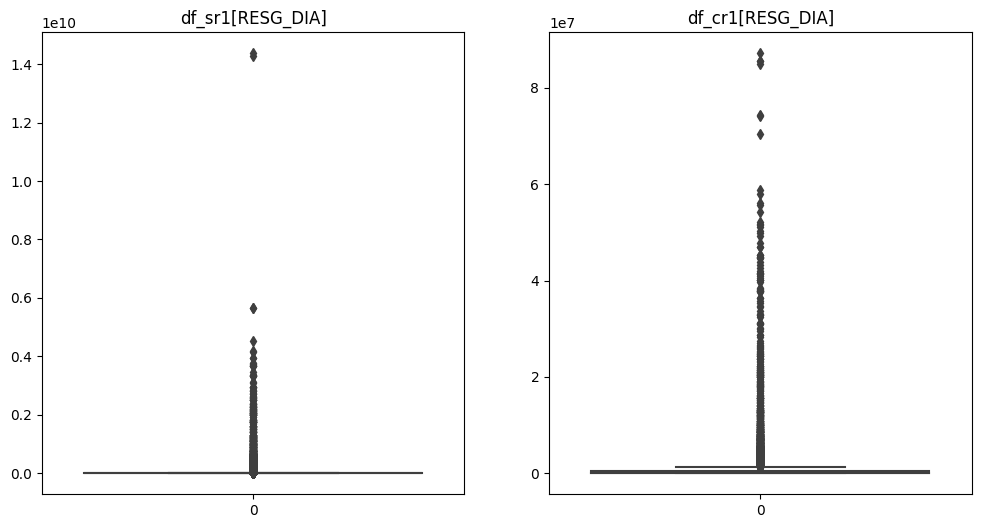

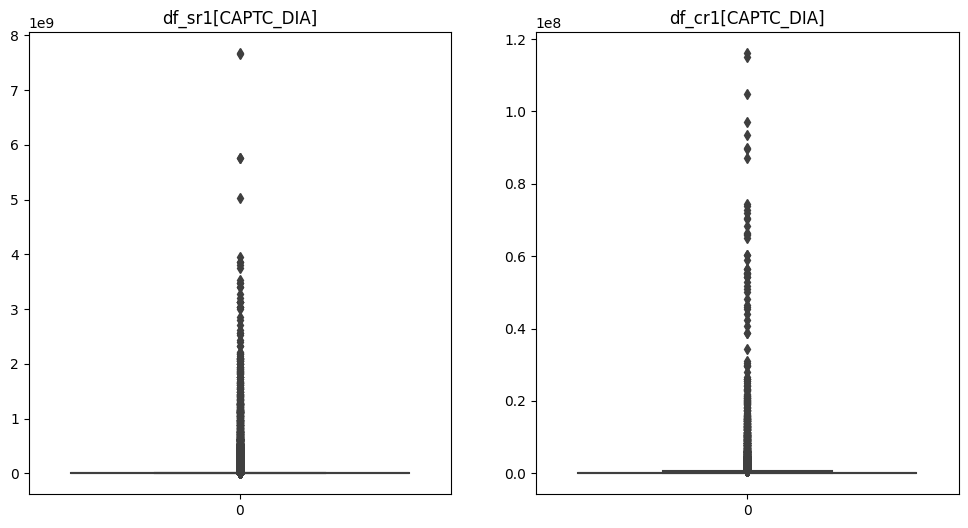

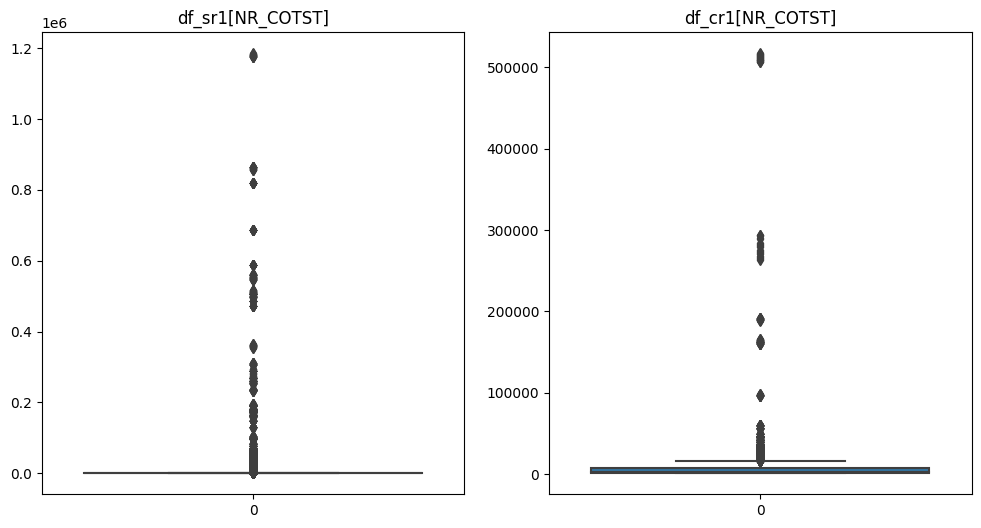

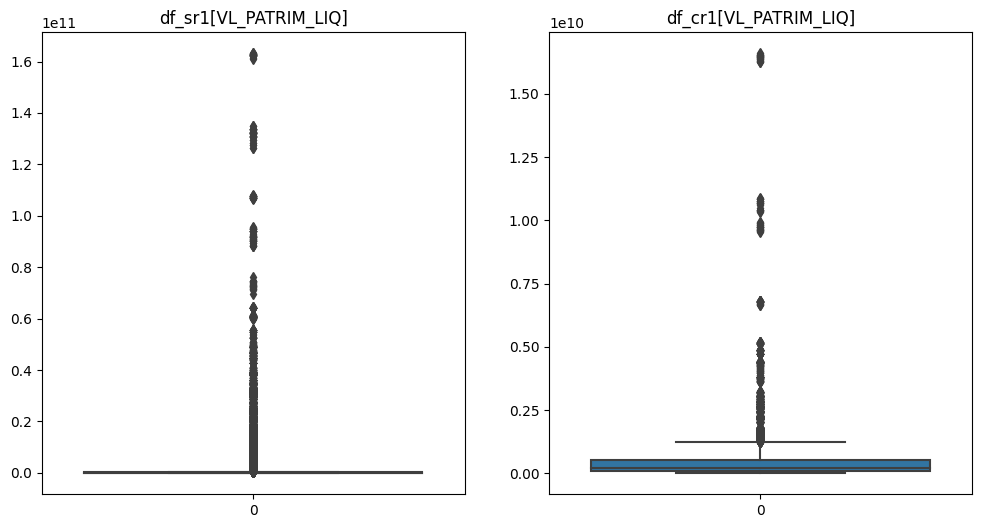

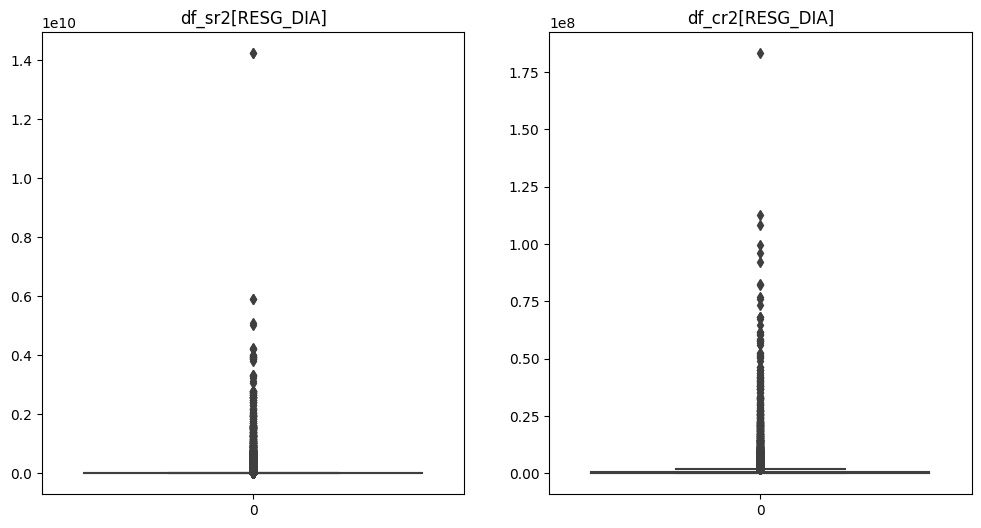

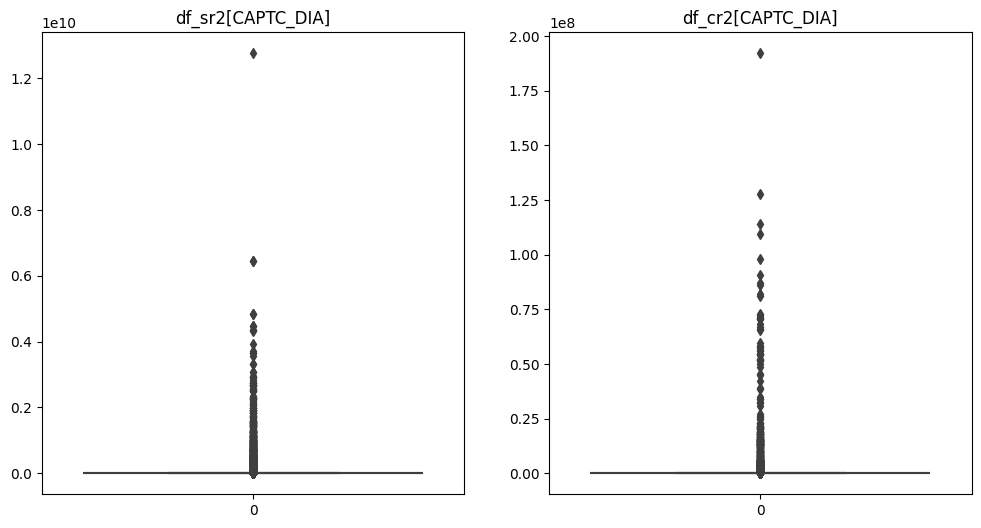

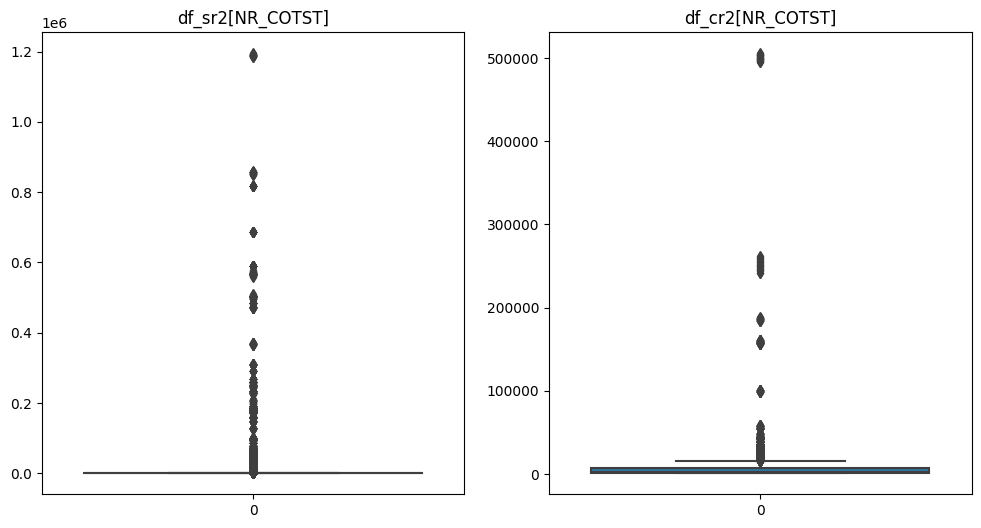

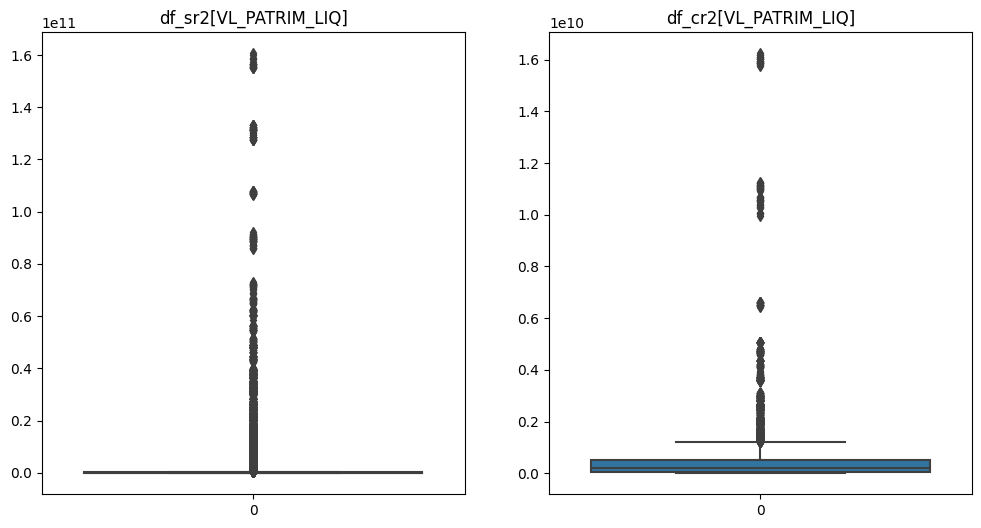

In [121]:
# Comparando o número de linhas e colunas
data = {
    'df_sr1': df_sr1.shape,
    'df_cr1': df_cr1.shape,
    'df_sr2': df_sr2.shape,
    'df_cr2': df_cr2.shape
}

df_exib = pd.DataFrame(data, index=['Número de linhas', 'Número de colunas'])

print(df_exib)
print()

# Definindo os dataframes e as colunas que se quer plotar
dataframes = [(df_sr1, df_cr1), (df_sr2, df_cr2)]
colunas = ['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ']

# Para cada par de dataframes
for i, (df1, df2) in enumerate(dataframes):

    # Para cada coluna
    for j, col in enumerate(colunas):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        sns.boxplot(ax=axs[0], data=df1[col].values)
        axs[0].set_title(f'df_sr{i+1}[{col}]')

        sns.boxplot(ax=axs[1], data=df2[col].values)
        axs[1].set_title(f'df_cr{i+1}[{col}]')

        plt.show()





### __Feature Selection and Engineering

In [122]:
# Considerando somente os dígitos referente ao "dia" em relação a
# DT_COMPTC (Data de competência do documento)
df_cr1['DT_COMPTC_DIA'] = df_cr1['DT_COMPTC'].str.slice(0, 2)
df_cr2['DT_COMPTC_DIA'] = df_cr2['DT_COMPTC'].str.slice(0, 2)

# Definindo o index para o JOIN
df_cr1.set_index(['CNPJ_FUNDO', 'DT_COMPTC_DIA'], inplace=True)
df_cr2.set_index(['CNPJ_FUNDO', 'DT_COMPTC_DIA'], inplace=True)

# JOIN os dois DataFrames usando o índice e gera o Dataframe de Atributos (df_atrib)
df_atrib = df_cr1.join(df_cr2, rsuffix='_1')

# Reseta o índice
df_atrib.reset_index(inplace=True)

# Calculando o retorno, dia a dia
df_atrib['RETORNO'] = (df_atrib['VL_QUOTA_1'] - df_atrib['VL_QUOTA']).round(5)

# Mantém somente as colunas referentes ao mês M (df_cr1)
df_atrib = df_atrib.filter(regex='[^_1]$')

### DEFININDO O ATRIBUTO ALVO ###
# Considerando que RETORNO > 0, o investimento É VIÁVEL (SUGESTÃO = 1), caso
# contrário INVIÁVEL (SUGESTÃO = 0)
df_atrib['SUGESTÃO'] = df_atrib['RETORNO'].apply(lambda x: 1 if x > 0 else 0)

# Limpa coluna RETORNO
df_atrib = df_atrib.replace(['#NOME?', '', '-Infinity'], np.nan)
df_atrib = df_atrib.dropna(subset=['RETORNO'])
df_atrib['RETORNO'] = df_atrib['RETORNO'].astype(str)
df_atrib = df_atrib.replace(['-Infinity', '-inf'], np.nan)
df_atrib = df_atrib.dropna(subset=['RETORNO'])
df_atrib = df_atrib.reset_index()

df_atrib['SUGESTÃO'] = df_atrib['SUGESTÃO'].astype(int)

# Concluindo o Feature Selection and engineering
df_atrib = df_atrib[['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', \
                     'SUGESTÃO']]

### __Tratando Outliers

In [123]:
####### TRATANDO OUTLIERS COM MÉTODO IQR (Interquartile Range) #######

# Salvando a coluna 'SUGESTÃO' em um DataFrame separado antes do tratamento dos outliers
df_sugestao = df_atrib[['SUGESTÃO']]

df_iqr = df_atrib[['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ']]

# Calculando IQR
Q1 = df_iqr.quantile(0.25)
Q3 = df_iqr.quantile(0.75)
IQR = Q3 - Q1

# Os outliers são então definidos como observações que estão abaixo de (Q1 - 1.5 * IQR)
# ou acima de (Q3 + 1.5 * IQR).
df_iqr = df_iqr[~((df_iqr < (Q1 - 1.5 * IQR)) | (df_iqr > (Q3 + 1.5 * IQR))).any(axis=1)]

# Junte 'df_sugestao' de volta a 'df_iqr'
df_atrib = df_iqr.merge(df_sugestao, left_index=True, right_index=True)

print(df_atrib.shape)
print()
df_atrib


(4751, 5)



,RESG_DIA,CAPTC_DIA,NR_COTST,VL_PATRIM_LIQ,SUGESTÃO
0,33725.63,0.00,1285,2.706602e+08,1
1,0.00,0.00,1285,2.708698e+08,1
2,0.00,52834.39,1286,2.707104e+08,1
3,233455.80,3364.69,1280,2.713893e+08,1
4,18098.13,0.00,1279,2.716907e+08,1
...,...,...,...,...,...
6745,195382.56,0.00,3363,1.128446e+08,1
6746,290403.41,0.00,3357,1.127229e+08,1
6747,14528.14,67024.97,1290,1.347824e+06,1
6748,0.00,57260.21,1382,1.404994e+06,1


### __Apresentação dos Atributos (Avaliando os atributos antes da separação treino/teste)

* Avaliação de df_atrib:
              df_atrib_dtypes  df_atrib_count
RESG_DIA              float64            4751
CAPTC_DIA             float64            4751
NR_COTST                int64            4751
VL_PATRIM_LIQ         float64            4751
SUGESTÃO                int64            4751

** SUGESTÃO
0    2660
1    2091



,RESG_DIA,CAPTC_DIA,NR_COTST,VL_PATRIM_LIQ,SUGESTÃO
count,4.751000e+03,4751.000000,4751.000000,4.751000e+03,4751.000000
mean,1.845667e+05,57689.316510,3714.432751,2.035469e+08,0.440118
std,2.955017e+05,109279.466909,3312.303517,2.258955e+08,0.496453
min,0.000000e+00,0.000000,1006.000000,1.120432e+06,0.000000
25%,0.000000e+00,0.000000,1468.000000,5.086067e+07,0.000000
50%,4.894653e+04,5000.000000,2315.000000,1.170545e+08,0.000000
75%,2.299946e+05,60000.000000,4602.000000,2.639645e+08,1.000000
max,1.422596e+06,554039.450000,15979.000000,1.193216e+09,1.000000


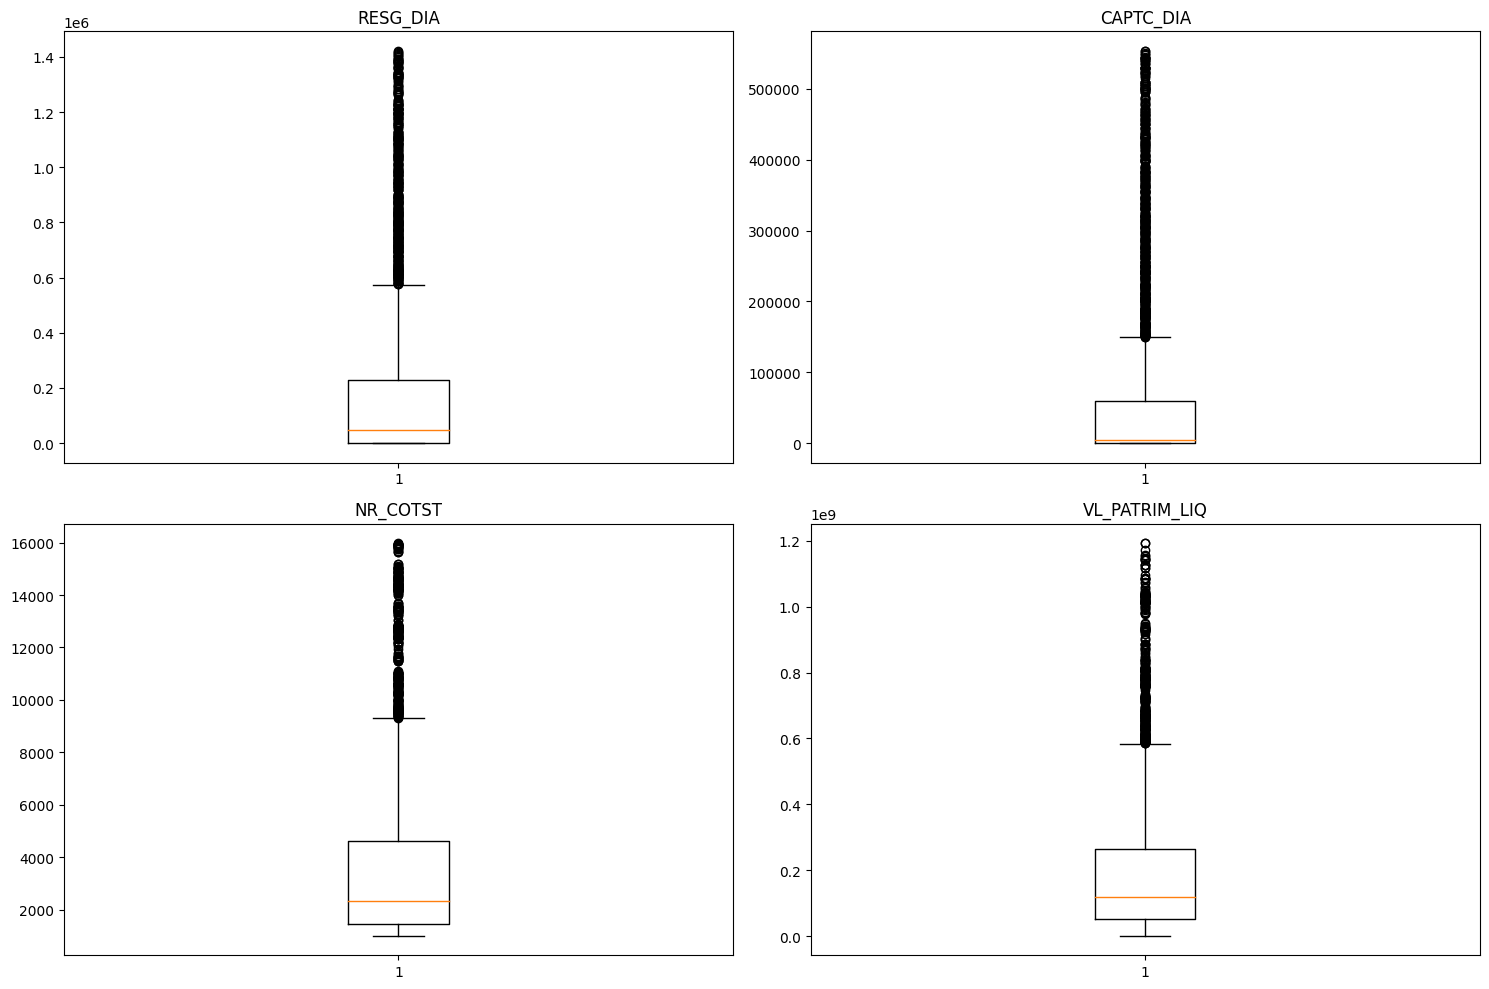

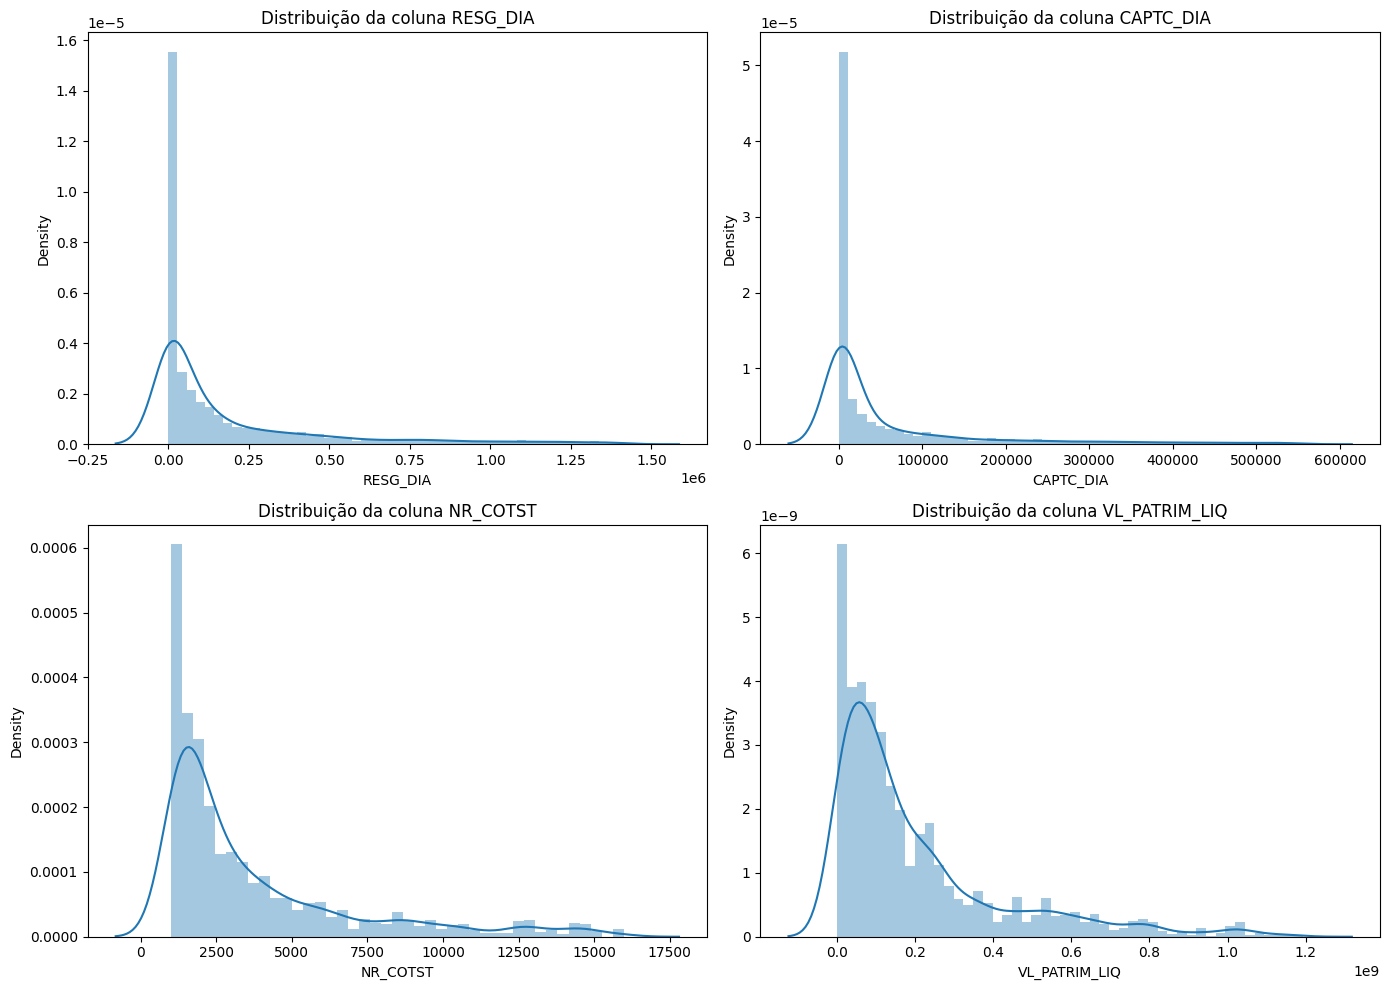

In [124]:
####### AVALIANDO OS DADOS #######

### DADOS TABELADOS ###

# Criação de DataFrames temporários para armazenar os tipos de dados e contagens
temp1 = pd.DataFrame(df_atrib.dtypes, columns=['df_atrib_dtypes'])
temp2 = pd.DataFrame(df_atrib.count(), columns=['df_atrib_count'])

# Criação de DataFrames temporários para armazenar as informações de shape
temp3 = pd.DataFrame([df_atrib.shape])

# Concatenação dos DataFrames lado a lado
result = pd.concat([temp1, temp2], axis=1)

# Comportamento de SUGESTÃO
counts = df_atrib['SUGESTÃO'].value_counts()

# Exibição do resultado
print("* Avaliação de df_atrib:")
print(result)
print()
print("** SUGESTÃO")
print(counts.to_string(dtype=False))
print()
display(df_atrib.describe())

### BOXPLOT ###

df_box = df_atrib[['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', \
                     'VL_PATRIM_LIQ']]

cols = ['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', \
                     'VL_PATRIM_LIQ']

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, col in enumerate(cols):
    ax = axs[i//2, i%2]  # Determina a posição do subplot
    ax.boxplot(df_box[col])
    ax.set_title(col)

plt.tight_layout()
plt.show()

### DISTRIBUIÇÃO LINEAR ###

# Lista das colunas a visualizar
cols = ['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ']

# Cria uma figura com 2 linhas e 2 colunas de subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Para cada coluna, cria um gráfico de distribuição linear
for i, col in enumerate(cols):
    sns.distplot(df_atrib[col], ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title('Distribuição da coluna {}'.format(col))

plt.tight_layout()
plt.show()

### __Separação em conjunto de treino e conjunto de teste com holdout

In [125]:
####### DEFININDO PARÂMETROS DO CONJUNTO DE TESTES #######

test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = df_atrib.values
X = array[:,0:4]
y = array[:,4]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação


## _Modelagem e Inferência

### __Criação e avaliação de modelos: linha base

KNN: 0.684737 (0.017763)
CART: 0.770263 (0.027324)
NB: 0.571053 (0.015025)
SVM: 0.554474 (0.007632)


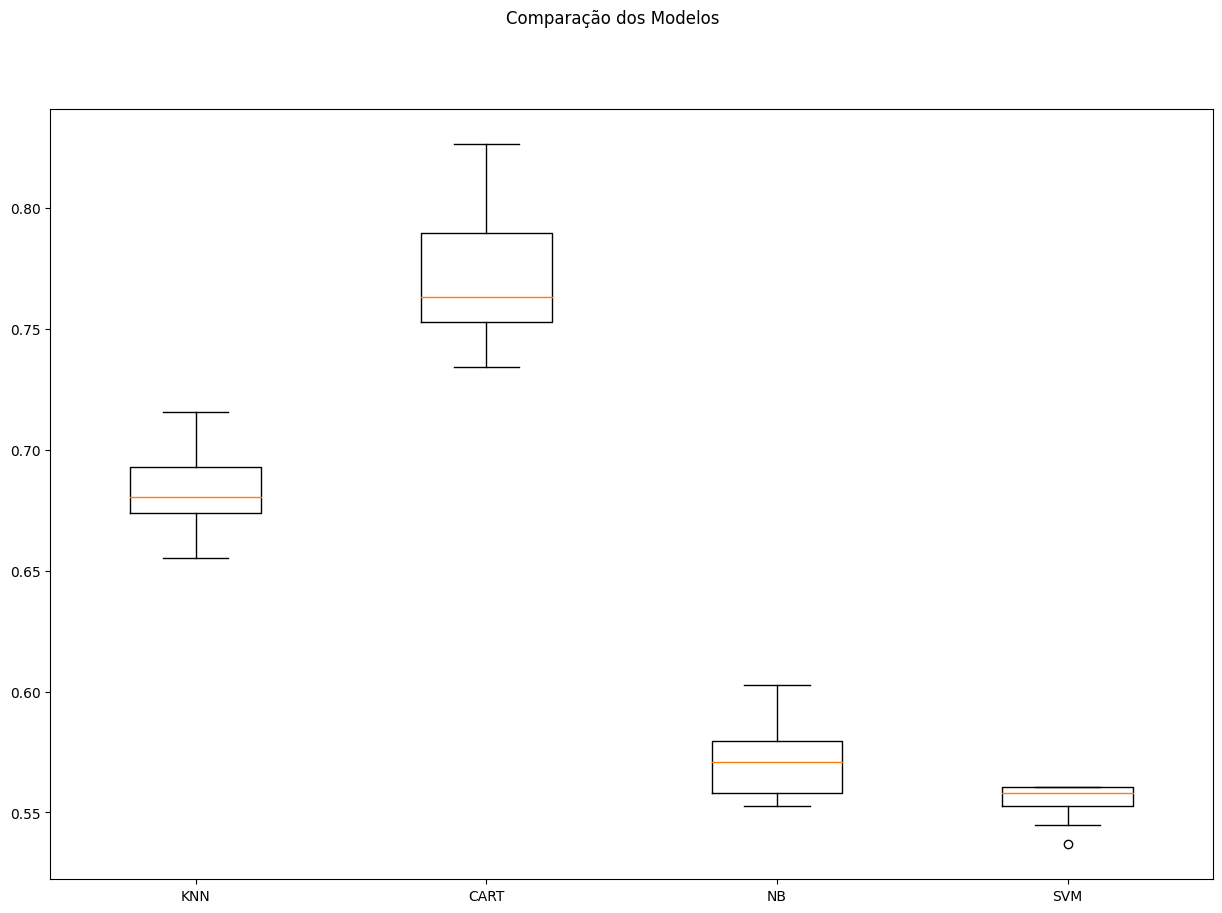

In [126]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### __Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.685 (0.018)
CART-orig: 0.770 (0.027)
NB-orig: 0.571 (0.015)
SVM-orig: 0.554 (0.008)
KNN-padr: 0.657 (0.023)
CART-padr: 0.773 (0.022)
NB-padr: 0.567 (0.015)
SVM-padr: 0.604 (0.015)
KNN-norm: 0.658 (0.021)
CART-norm: 0.774 (0.023)
NB-norm: 0.567 (0.015)
SVM-norm: 0.601 (0.016)


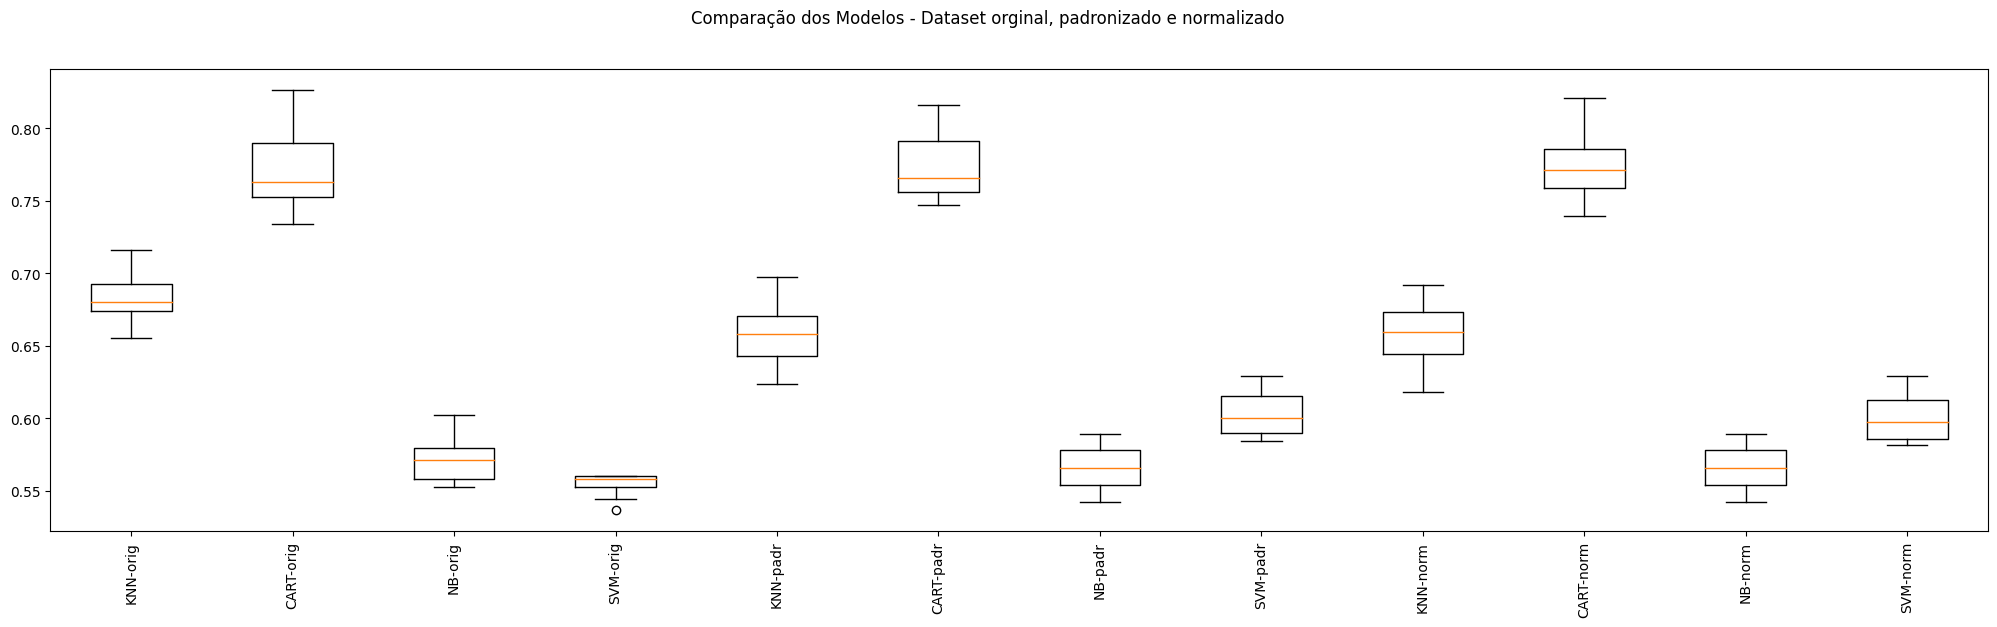

In [127]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### __Otimização dos hiperparâmetros

In [128]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
results = []
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # armazena os resultados
    results.append((name, grid.best_score_, grid.best_params_))
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

# Encontra o modelo com a maior pontuação
best_model = max(results, key=lambda item:item[1])
print("\nO melhor modelo é: %s - Pontuação: %f usando %s" % best_model)


Sem tratamento de missings: knn-orig - Melhor: 0.695789 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5}
Sem tratamento de missings: knn-padr - Melhor: 0.706053 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1}
Sem tratamento de missings: knn-norm - Melhor: 0.707105 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1}

O melhor modelo é: knn-norm - Pontuação: 0.707105 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1}


## _Finalização do Modelo

In [129]:
# Coletando os dados do melhor modelo
pattern = best_model[0]
score = best_model[1]
params = best_model[2]
metric = params['KNN__metric']
n_neighbors = params['KNN__n_neighbors']

# Define scaler conforme o melhor modelo encontrado
if pattern == "knn-orig":
  scaler = KNeighborsClassifier().fit(X_train)
elif pattern == "knn-padr":
  scaler = StandardScaler().fit(X_train)
elif pattern == "knn-norm":
  scaler = MinMaxScaler().fit(X_train)

# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric=metric, n_neighbors=n_neighbors)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)

print("\nConsiderando o melhor modelo como: %s - Pontuação: %f usando %s" % best_model)
print("A Avaliação do modelo com o conjunto de testes tem acurácia de: %f" % accuracy_score(y_test, predictions))



Considerando o melhor modelo como: knn-norm - Pontuação: 0.707105 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1}
A Avaliação do modelo com o conjunto de testes tem acurácia de: 0.667718


In [130]:
# Preparação do modelo com TODO o dataset
# Define scaler conforme o melhor modelo encontrado
if pattern == "knn-orig":
  scaler = KNeighborsClassifier().fit(X)
elif pattern == "knn-padr":
  scaler = StandardScaler().fit(X)
elif pattern == "knn-norm":
  scaler = MinMaxScaler().fit(X)

rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

# SIMULAÇÃO - Abra esta seção para realizar simulação de dados no modelo.

In [109]:
#@title Insira os valores conforme as seguintes restrições: NR_COTST>=1.000 e VL_PATRIM_LIQ>= 1.000.000
RESG_DIA = 206597.83 #@param {type:"number"}
CAPTC_DIA = 253153.06 #@param {type:"number"}
NR_COTST = 6747 #@param {type:"integer"}
VL_PATRIM_LIQ = 378217028.71 #@param {type:"number"}

# Verificando as restrições
if RESG_DIA < 0 or CAPTC_DIA < 0:
    print("Erro: RESG_DIA e CAPTC_DIA devem ser maiores ou iguais a zero.")
elif NR_COTST < 1000:
    print("Erro: NR_COTST deve ser um número inteiro positivo maior que 1000.")
elif VL_PATRIM_LIQ < 1000000:
    print("Erro: VL_PATRIM_LIQ deve ser um número positivo maior que 1000000.")
else:
    print("Todos os valores estão dentro das restrições.")

    data = {'RESG_DIA': [RESG_DIA],
            'CAPTC_DIA': [CAPTC_DIA],
            'NR_COTST': [NR_COTST],
            'VL_PATRIM_LIQ': [VL_PATRIM_LIQ],
            }

    atributos = ['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ']
    entrada = pd.DataFrame(data, columns=atributos)

    array_entrada = entrada.values
    X_entrada = array_entrada[:,0:4].astype(float)

    # Padronização nos dados de entrada usando o scaler utilizado em X
    rescaledEntradaX = scaler.transform(X_entrada)

    # Predição de classes dos dados de entrada
    saidas = model.predict(rescaledEntradaX)

    print("Dados de Entrada:", RESG_DIA, CAPTC_DIA, NR_COTST, VL_PATRIM_LIQ)
    print()
    print("Dados Padronizados:", rescaledEntradaX)
    print()

    if saidas == 1:
        resultado = "Viável"
    elif saidas == 0:
        resultado = "Inviável"
    print("Resultado:", resultado)
    print("Note que esta avaliação só considera se o resultado previsto para um investimento com carência de 30 dias será positivo ou não.")

Todos os valores estão dentro das restrições.
Dados de Entrada: 1545378.88 253153.06 6747 378217028.71

Dados Padronizados: [[1.08630883 0.45692244 0.3834235  0.31633073]]

Resultado: Viável
Note que esta avaliação só considera se o resultado previsto para um investimento com carência de 30 dias será positivo ou não.


## _Teste massivo

In [112]:
# Novos dados - não sabemos a classe!
data = {'RESG_DIA':  [22564, 0.0, 0.0],
        'CAPTC_DIA': [211524.8, 543051.92, 300.28],
        'NR_COTST': [3835, 13956, 3317],
        'VL_PATRIM_LIQ': [80334691.1, 751324937.95, 1080548.72],
        }

atributos = ['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:4].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[[ 1.58611411e-02  3.81786532e-01  1.88940092e-01  6.64495630e-02]
 [ 0.00000000e+00  9.80168326e-01  8.64890136e-01  6.29315509e-01]
 [ 0.00000000e+00  5.41983066e-04  1.54344487e-01 -3.34566845e-05]]
[1. 1. 1.]


# EXPORTANDO MODELO - Salvando Modelo

In [131]:
# Salvando o modelo no google drive
drive.mount('/content/gdrive')

path = "/content/gdrive/My Drive/"
pickle_out = open(path + 'Modelo_FI_Multi.pkl', 'wb')
pickle.dump(model, pickle_out)
pickle_out.close()

print(os.path.join(path, 'Modelo_FI_Multi.pkl'))
print(os.getcwd())

Mounted at /content/gdrive
/content/gdrive/My Drive/Modelo_FI_Multi.pkl
/content
